<a id = "table_of_contents"></a>
# Table of contents

[Import of libraries](#imports)

[Global variables](#global_variables)

[Sales import and generate a full df with all data and records](#generate_full_df_with_all_records)

[Join the full_df with gb_df](#join_dfs)

[Generate additional features](#create_new_features)

-->[Date and shop_id features](#feature_1)

-->[Date and item_category features](#feature_3)

[Join full sales df with all the features generated](#join_dfs_with_features)

[Basic model train](#basic_model)

[Feature importance](#feature_importance_1)

[Predict and model evaluation](#predict_and_model_evaluation_1)

[Submission to Kaggle](#submission_kaggle)

<a id = "imports"></a>
# Import of libraries
[Go back to the table of contents](#table_of_contents)

In [1]:
# import the basic libraries we will use in this kernel
import os
import numpy as np
import pandas as pd
import pickle

import time
import datetime
from datetime import datetime
import calendar

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from string import punctuation

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder

import itertools
import warnings

warnings.filterwarnings("ignore") # specify to ignore warning messages

<a id = "global_variables"></a>
# Global variables
[Go back to the table of contents](#table_of_contents)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id = "generate_full_df_with_all_records"></a>
# Sales import and generate a full df with all data and records
[Go back to the table of contents](#table_of_contents)

In [3]:
sales_df = pd.read_csv("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/DF_FINAL.csv", index_col = 0)

In [4]:
cols_to_drop = [
 "day", "sales_2011", "sales_2012", "sales_2013"
]

sales_df.drop(cols_to_drop, inplace = True, axis = 1)

In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5345528 entries, 0 to 5345527
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               object 
 1   item             object 
 2   category         object 
 3   department       object 
 4   store            object 
 5   store_code       object 
 6   region           object 
 7   date             object 
 8   sell_price       float64
 9   year             int64  
 10  week             int64  
 11  sales            float64
 12  month            int64  
 13  weekday_int      float64
 14  weekend_sales    float64
 15  event_dummy      float64
 16  event_sales      float64
 17  units            int64  
 18  summer_sales     int64  
 19  christmas_sales  int64  
 20  sales_2014       int64  
 21  sales_2015       int64  
 22  sales_2016       int64  
dtypes: float64(6), int64(9), object(8)
memory usage: 978.8+ MB


In [6]:
sales_df.region.value_counts()

New York        2115712
Boston          1636338
Philadelphia    1593478
Name: region, dtype: int64

In [7]:
encoder = LabelEncoder()
encoder.fit(sales_df["region"])
sales_df["region"] = encoder.transform(sales_df["region"])
sales_df["region"] = LabelEncoder().fit_transform(sales_df["region"])

In [8]:
sales_df.isnull().sum()

id                 0
item               0
category           0
department         0
store              0
store_code         0
region             0
date               0
sell_price         0
year               0
week               0
sales              0
month              0
weekday_int        0
weekend_sales      0
event_dummy        0
event_sales        0
units              0
summer_sales       0
christmas_sales    0
sales_2014         0
sales_2015         0
sales_2016         0
dtype: int64

In [9]:
sales_df.rename(columns={'id': 'unique_id', 'units': 'item_cnt_day', 'sell_price': 'item_price', "sales" : "revenue"}, inplace=True)

In [10]:
x = 0
y = 2

In [11]:
print(x)
print(len(sales_df))
sales_df.drop(sales_df[sales_df['region'] == x].index, inplace = True)
print(len(sales_df))

0
5345528
3709190


In [12]:
print(y)
print(len(sales_df))
sales_df.drop(sales_df[sales_df['region'] == y].index, inplace = True)
print(len(sales_df))

2
3709190
2115712


In [13]:
z = sales_df.revenue.mean()
z

39.90047253123299

In [14]:
print(z)
print(len(sales_df))
sales_df.drop(sales_df[sales_df['revenue'] <= z].index, inplace = True)
print(len(sales_df))

39.90047253123299
2115712
599167


In [15]:
type(sales_df["date"].iloc[0])

str

In [16]:
# convert to datetime the date column
# specify the format since otherwise it might give some problems
sales_df["date"] = pd.to_datetime(sales_df["date"], format = "%Y-%m-%d")

In [17]:
# max date in sales is 30.09.2015.
# In the Kaggle competition we are asked to predict the sales for the next month
# this means the sales of October
min_date = sales_df["date"].min()
max_date_sales = sales_df["date"].max()

In [18]:
max_date_sales

Timestamp('2016-04-18 00:00:00')

In [19]:
# how to create a new date
max_date_test = datetime(2016, 4, 18)

In [20]:
date_range = pd.date_range(min_date, max_date_test, freq = "M")
print("We have a total of {} months".format(len(date_range)))
date_range

We have a total of 61 months


DatetimeIndex(['2011-03-31', '2011-04-30', '2011-05-31', '2011-06-30',
               '2011-07-31', '2011-08-31', '2011-09-30', '2011-10-31',
               '2011-11-30', '2011-12-31', '2012-01-31', '2012-02-29',
               '2012-03-31', '2012-04-30', '2012-05-31', '2012-06-30',
               '2012-07-31', '2012-08-31', '2012-09-30', '2012-10-31',
               '2012-11-30', '2012-12-31', '2013-01-31', '2013-02-28',
               '2013-03-31', '2013-04-30', '2013-05-31', '2013-06-30',
               '2013-07-31', '2013-08-31', '2013-09-30', '2013-10-31',
               '2013-11-30', '2013-12-31', '2014-01-31', '2014-02-28',
               '2014-03-31', '2014-04-30', '2014-05-31', '2014-06-30',
               '2014-07-31', '2014-08-31', '2014-09-30', '2014-10-31',
               '2014-11-30', '2014-12-31', '2015-01-31', '2015-02-28',
               '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30',
               '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
      

In [21]:
unique_id = sales_df["unique_id"].unique()

In [22]:
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["date", "unique_id"])
len(cartesian_product)

597800

We will be working with a DataFrame resampled by Months. We must resample the sales_df.

In [23]:
# # set index
sales_df["revenue"] = sales_df["item_cnt_day"] * sales_df["item_price"]

In [24]:
sales_df.head(5)

,unique_id,item,category,department,store,store_code,region,date,item_price,year,...,weekday_int,weekend_sales,event_dummy,event_sales,item_cnt_day,summer_sales,christmas_sales,sales_2014,sales_2015,sales_2016
7,ACCESORIES_1_004_NYC_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,1,2011-03-07,5.77,2011,...,21.0,13.0,0.0,0.0,22,0,0,0,0,0
8,ACCESORIES_1_004_NYC_3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Tribeca,NYC_3,1,2011-03-07,5.77,2011,...,5.0,0.0,0.0,0.0,12,0,0,0,0,0
9,ACCESORIES_1_004_NYC_4,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Brooklyn,NYC_4,1,2011-03-07,5.77,2011,...,16.0,5.0,0.0,0.0,7,0,0,0,0,0
16,ACCESORIES_1_008_NYC_3,ACCESORIES_1_008,ACCESORIES,ACCESORIES_1,Tribeca,NYC_3,1,2011-03-07,0.56,2011,...,28.0,89.0,0.0,0.0,187,0,0,0,0,0
23,ACCESORIES_1_009_NYC_1,ACCESORIES_1_009,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,1,2011-03-07,2.07,2011,...,10.0,6.0,0.0,0.0,20,0,0,0,0,0


In [25]:
sales_df.item_price.describe()

count    599167.000000
mean          6.579913
std           5.323499
min           0.240000
25%           3.000000
50%           4.800000
75%           8.460000
max          41.200000
Name: item_price, dtype: float64

In [26]:
print(len(sales_df))

599167


In [27]:
st = time.time()

gb_df = sales_df.set_index("date")

# # groupby shop_id and item_id
gb_df = gb_df.groupby(["unique_id"])

# # resample the sales to a monthly basis
gb_df = gb_df.resample("M").agg({'item_cnt_day':np.sum, "item_price":np.mean, "revenue":np.sum})

# # convert to dataframe and save the full dataframe
gb_df.reset_index(inplace = True)

et = time.time()

print("Total time in minutes to preprocess took {}".format((et - st)/60))

Total time in minutes to preprocess took 2.1893993179003397


In [28]:
gb_df.head(2)

,unique_id,date,item_cnt_day,item_price,revenue
0,ACCESORIES_1_001_NYC_1,2013-08-31,5,10.99,54.95
1,ACCESORIES_1_001_NYC_1,2013-09-30,16,10.99,175.84


In [29]:
print(len(gb_df))

389023


In [30]:
gb_df.to_pickle("gb_df_NY.pkl")
sales_df.to_pickle("sales_df_NY.pkl")

<a id = "join_dfs"></a>
# Join the full_df with gb_df
[Go back to the table of contents](#table_of_contents)

Now that we have the sales_df resampled by months, and we have created a cartesian product (all possible combinations of months, shop_id and item_id), let's merge the df.

In [31]:
PATH_DATA = "../input/df-time-series"
gb_df = pd.read_pickle("./gb_df_NY.pkl")
sales_df = pd.read_pickle("./sales_df_NY.pkl")

In [32]:
# max date in sales is 30.09.2015.
# In the Kaggle competition we are asked to predict the sales for the next month
# this means the sales of October
min_date = sales_df["date"].min()
max_date_sales = sales_df["date"].max()
# how to create a new date
max_date_test = datetime(2016, 4, 18)
date_range = pd.date_range(min_date, max_date_test, freq = "M")
print("We have a total of {} months".format(len(date_range)))
date_range
unique_id = sales_df["unique_id"].unique()
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["date", "unique_id"])
len(cartesian_product)

We have a total of 61 months


597800

In [33]:
sales_df.head(2)

,unique_id,item,category,department,store,store_code,region,date,item_price,year,...,weekday_int,weekend_sales,event_dummy,event_sales,item_cnt_day,summer_sales,christmas_sales,sales_2014,sales_2015,sales_2016
7,ACCESORIES_1_004_NYC_2,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Harlem,NYC_2,1,2011-03-07,5.77,2011,...,21.0,13.0,0.0,0.0,22,0,0,0,0,0
8,ACCESORIES_1_004_NYC_3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Tribeca,NYC_3,1,2011-03-07,5.77,2011,...,5.0,0.0,0.0,0.0,12,0,0,0,0,0


In [34]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

full_df = pd.merge(full_df, gb_df, on = ['date','unique_id'], how = 'left')

full_df["item_cnt_day"] = np.clip(full_df["item_cnt_day"], 0, 30)

In [35]:
print(len(sales_df))
print(len(gb_df))

599167
389023


In [36]:
gb_df.revenue.describe()

count    389023.000000
mean        168.598514
std         386.173515
min           0.000000
25%           0.000000
50%          45.080000
75%         207.060000
max       25893.400000
Name: revenue, dtype: float64

In [37]:
y = gb_df["revenue"].mean()

In [38]:
print(y)
print(len(gb_df))
gb_df.drop(gb_df[gb_df['revenue'] <= y].index, inplace = True)
print(len(gb_df))

168.598514149549
389023
112258


In [39]:
gb_df.head()

,unique_id,date,item_cnt_day,item_price,revenue
1,ACCESORIES_1_001_NYC_1,2013-09-30,16,10.99,175.84
3,ACCESORIES_1_001_NYC_1,2013-11-30,17,10.99,186.83
4,ACCESORIES_1_001_NYC_1,2013-12-31,18,10.99,197.82
10,ACCESORIES_1_001_NYC_1,2014-06-30,17,10.99,186.83
13,ACCESORIES_1_001_NYC_1,2014-09-30,23,10.99,252.77


In [40]:
print(full_df.shape)

(597800, 5)


In [41]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597800 entries, 0 to 597799
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          597800 non-null  datetime64[ns]
 1   unique_id     597800 non-null  object        
 2   item_cnt_day  383975 non-null  float64       
 3   item_price    208223 non-null  float64       
 4   revenue       383975 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 27.4+ MB


In [42]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599167 entries, 7 to 5345523
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unique_id        599167 non-null  object        
 1   item             599167 non-null  object        
 2   category         599167 non-null  object        
 3   department       599167 non-null  object        
 4   store            599167 non-null  object        
 5   store_code       599167 non-null  object        
 6   region           599167 non-null  int64         
 7   date             599167 non-null  datetime64[ns]
 8   item_price       599167 non-null  float64       
 9   year             599167 non-null  int64         
 10  week             599167 non-null  int64         
 11  revenue          599167 non-null  float64       
 12  month            599167 non-null  int64         
 13  weekday_int      599167 non-null  float64       
 14  weekend_sales    59

In [43]:
additional_info = sales_df[["region", "store_code", "store", "category", "item", "department", "unique_id"]].drop_duplicates()

In [44]:
print(full_df.shape)

full_df = pd.merge(
    left = full_df,
    right = additional_info,
    how = "left",
    on = "unique_id"
)
print(full_df.shape)

(597800, 5)
(597800, 11)


In [45]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597800 entries, 0 to 597799
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          597800 non-null  datetime64[ns]
 1   unique_id     597800 non-null  object        
 2   item_cnt_day  383975 non-null  float64       
 3   item_price    208223 non-null  float64       
 4   revenue       383975 non-null  float64       
 5   region        597800 non-null  int64         
 6   store_code    597800 non-null  object        
 7   store         597800 non-null  object        
 8   category      597800 non-null  object        
 9   item          597800 non-null  object        
 10  department    597800 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 54.7+ MB


In [46]:
full_df["item_cnt_day"].fillna(0, inplace = True)
full_df["item_price"].fillna(0, inplace = True)
full_df["revenue"].fillna(0, inplace = True)

In [47]:
full_df["item_price"] = full_df.groupby("unique_id")["item_price"].apply(lambda series: series.backfill().ffill())

In [48]:
full_df.isnull().sum()

date            0
unique_id       0
item_cnt_day    0
item_price      0
revenue         0
region          0
store_code      0
store           0
category        0
item            0
department      0
dtype: int64

In [49]:
full_df.to_pickle("full_df_NY.pkl")

<a id = "create_new_features"></a>
# Generate additional features
[Go back to the table of contents](#table_of_contents)

In [50]:
PATH_DATA = "../input/df-time-series"
full_df = pd.read_pickle("./full_df_NY.pkl")

In [51]:
encoder = LabelEncoder()
encoder.fit(full_df["store_code"])
full_df["store_code"] = encoder.transform(full_df["store_code"])
full_df["store_code"] = LabelEncoder().fit_transform(full_df["store_code"])

encoder = LabelEncoder()
encoder.fit(full_df["category"])
full_df["category"] = encoder.transform(full_df["category"])
full_df["category"] = LabelEncoder().fit_transform(full_df["category"])

encoder = LabelEncoder()
encoder.fit(full_df["department"])
full_df["department"] = encoder.transform(full_df["department"])
full_df["department"] = LabelEncoder().fit_transform(full_df["department"])

encoder = LabelEncoder()
encoder.fit(full_df["item"])
full_df["item"] = encoder.transform(full_df["item"])
full_df["item"] = LabelEncoder().fit_transform(full_df["item"])

In [52]:
def build_ts_features(full_df, gb_list, agg_func, agg_func_name, target_column = "item_cnt_day", verbose = True) -> pd.DataFrame:
    '''
    Based on the full_df you pass and the gb_list, this functions creates Time Series features and returns
    a gb_df.
    '''
    
    # create dynamic name
    feature_name = "_".join(gb_list)
    
    if verbose: print(f"Working with {feature_name}")
    
    # first sales/DataFrame aggregation
    gb_df = full_df.groupby(
        gb_list
    )[target_column].apply(
        agg_func
    ).reset_index().rename(
        columns = {target_column : feature_name + "_" + agg_func_name}
    )
    
    # add lags features
    gb_df[feature_name + "_" + agg_func_name + "_" + "shift_1"] = gb_df.groupby(gb_list[1:])[feature_name + "_" + agg_func_name].transform(
        lambda series: series.shift(1)
    )
    
    return gb_df

In [53]:
full_df.isnull().sum()

date            0
unique_id       0
item_cnt_day    0
item_price      0
revenue         0
region          0
store_code      0
store           0
category        0
item            0
department      0
dtype: int64

In [54]:
full_df.to_pickle("full_df_NY.pk2")

<a id = "feature_1"></a>
## Date and shop_id features
[Go back to the table of contents](#table_of_contents)

In [55]:
full_df = pd.read_pickle("./full_df_NY.pk2")

In [56]:
st = time.time()

gb_list = ["date", "store_code"]

shop_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_store_code


0.0013878703117370605

In [57]:
shop_sales_features.shape

(244, 4)

In [58]:
st = time.time()

gb_list = ["date", "region"]

region_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_region


0.0011323889096577962

In [59]:
region_sales_features

,date,region,date_region_sales_sum,date_region_sales_sum_shift_1
0,2011-03-31,1,68616.0,NaN
1,2011-04-30,1,69042.0,68616.0
2,2011-05-31,1,75512.0,69042.0
3,2011-06-30,1,71211.0,75512.0
4,2011-07-31,1,71881.0,71211.0
...,...,...,...,...
56,2015-11-30,1,116856.0,113317.0
57,2015-12-31,1,90249.0,116856.0
58,2016-01-31,1,0.0,90249.0
59,2016-02-29,1,0.0,0.0


In [60]:
st = time.time()

gb_list = ["date", "department"]

department_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_department


0.0017383098602294922

In [61]:
department_sales_features

,date,department,date_department_sales_sum,date_department_sales_sum_shift_1
0,2011-03-31,0,8998.0,NaN
1,2011-03-31,1,194.0,NaN
2,2011-03-31,2,12059.0,NaN
3,2011-03-31,3,7660.0,NaN
4,2011-03-31,4,5959.0,NaN
...,...,...,...,...
422,2016-03-31,2,27306.0,0.0
423,2016-03-31,3,9034.0,0.0
424,2016-03-31,4,9514.0,0.0
425,2016-03-31,5,16530.0,0.0


In [62]:
st = time.time()

gb_list = ["date", "item"]

item_sales_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_item


0.28553775548934934

In [63]:
item_sales_features

,date,item,date_item_sales_sum,date_item_sales_sum_shift_1
0,2011-03-31,0,0.0,NaN
1,2011-03-31,1,0.0,NaN
2,2011-03-31,2,0.0,NaN
3,2011-03-31,3,49.0,NaN
4,2011-03-31,4,0.0,NaN
...,...,...,...,...
170063,2016-03-31,2783,43.0,0.0
170064,2016-03-31,2784,0.0,0.0
170065,2016-03-31,2785,39.0,0.0
170066,2016-03-31,2786,0.0,0.0


<a id = "feature_3"></a>
## Date and item_category features
[Go back to the table of contents](#table_of_contents)

In [64]:
st = time.time()

gb_list = ["date", "category"]

month_item_category_features = build_ts_features(
    full_df = full_df, 
    gb_list = gb_list, 
    agg_func = np.sum, 
    agg_func_name = "sales_sum",
    target_column = "item_cnt_day",
    verbose = True
)

et = time.time()

(et - st)/60

Working with date_category


0.001327371597290039

In [65]:
month_item_category_features.shape

(183, 4)

<a id = "join_dfs_with_features"></a>
# Join full sales df with all the features generated
[Go back to the table of contents](#table_of_contents)

In [66]:
print("Shape before merge is {}".format(full_df.shape))

full_df = pd.merge(full_df, shop_sales_features, on = ["date", "store_code"], how = "left")
full_df = pd.merge(full_df, month_item_category_features, on = ["date", "category"], how = "left")
full_df = pd.merge(full_df, item_sales_features, on = ["date", "item"], how = "left")
full_df = pd.merge(full_df, department_sales_features, on = ["date", "department"], how = "left")
full_df = pd.merge(full_df, region_sales_features, on = ["date", "region"], how = "left")

full_df.rename(columns = {"item_cnt_day":"sales"}, inplace = True)

print("Shape after merge is {}".format(full_df.shape))

Shape before merge is (597800, 11)
Shape after merge is (597800, 21)


In [67]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597800 entries, 0 to 597799
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   date                               597800 non-null  datetime64[ns]
 1   unique_id                          597800 non-null  object        
 2   sales                              597800 non-null  float64       
 3   item_price                         597800 non-null  float64       
 4   revenue                            597800 non-null  float64       
 5   region                             597800 non-null  int64         
 6   store_code                         597800 non-null  int64         
 7   store                              597800 non-null  object        
 8   category                           597800 non-null  int64         
 9   item                               597800 non-null  int64         
 10  department          

In [68]:
# save the file

st = time.time()

full_df.to_pickle("FULL_DF_SALES_ALL_FEATURES_NY.pkl")

et = time.time()
(et - st)/60

0.003059212366739909

<a id = "basic_model"></a>
# Basic model train
[Go back to the table of contents](#table_of_contents)

In [71]:
# load the preprocessed data
full_df = pd.read_pickle("FULL_DF_SALES_ALL_FEATURES_NY.pkl")
full_df["sales"] = np.clip(full_df["sales"], 0, 30)

# delete all the columns where lags features are - 1 (shift(1))
full_df = full_df[full_df["date"] > np.datetime64("2011-01-31")]

In [72]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597800 entries, 0 to 597799
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   date                               597800 non-null  datetime64[ns]
 1   unique_id                          597800 non-null  object        
 2   sales                              597800 non-null  float64       
 3   item_price                         597800 non-null  float64       
 4   revenue                            597800 non-null  float64       
 5   region                             597800 non-null  int64         
 6   store_code                         597800 non-null  int64         
 7   store                              597800 non-null  object        
 8   category                           597800 non-null  int64         
 9   item                               597800 non-null  int64         
 10  department          

In [73]:
full_df.isnull().sum()

date                                    0
unique_id                               0
sales                                   0
item_price                              0
revenue                                 0
region                                  0
store_code                              0
store                                   0
category                                0
item                                    0
department                              0
date_store_code_sales_sum               0
date_store_code_sales_sum_shift_1    9800
date_category_sales_sum                 0
date_category_sales_sum_shift_1      9800
date_item_sales_sum                     0
date_item_sales_sum_shift_1          9800
date_department_sales_sum               0
date_department_sales_sum_shift_1    9800
date_region_sales_sum                   0
date_region_sales_sum_shift_1        9800
dtype: int64

In [74]:
full_df["date_store_code_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_category_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_item_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_department_sales_sum_shift_1"].fillna(0, inplace = True)
full_df["date_region_sales_sum_shift_1"].fillna(0, inplace = True)

In [75]:
cols_to_drop = [

'revenue', 'store', "unique_id", "date_store_code_sales_sum", "date_category_sales_sum", "date_item_sales_sum", "date_department_sales_sum", "date_region_sales_sum"

]

full_df.drop(cols_to_drop, inplace = True, axis = 1)

In [76]:
full_df.head()

,date,sales,item_price,region,store_code,category,item,department,date_store_code_sales_sum_shift_1,date_category_sales_sum_shift_1,date_item_sales_sum_shift_1,date_department_sales_sum_shift_1,date_region_sales_sum_shift_1
0,2011-03-31,30.0,5.77,1,1,0,3,0,0.0,0.0,0.0,0.0,0.0
1,2011-03-31,12.0,5.77,1,2,0,3,0,0.0,0.0,0.0,0.0,0.0
2,2011-03-31,7.0,5.77,1,3,0,3,0,0.0,0.0,0.0,0.0,0.0
3,2011-03-31,30.0,0.56,1,2,0,7,0,0.0,0.0,0.0,0.0,0.0
4,2011-03-31,20.0,2.07,1,0,0,8,0,0.0,0.0,0.0,0.0,0.0


In [77]:
# ------------------------------------------------------
# separate the dates for train, validation and test

train_index = sorted(list(full_df["date"].unique()))[:-2]

valida_index = [sorted(list(full_df["date"].unique()))[-2]]

test_index = [sorted(list(full_df["date"].unique()))[-1]]

In [78]:
# ------------------------------------------------------
# split the data into train, validation and test dataset
# we "simulate" the test dataset to be the Kaggle test dataset

X_train = full_df[full_df["date"].isin(train_index)].drop(['sales', "date"], axis=1)
Y_train = full_df[full_df["date"].isin(train_index)]['sales']

X_valida = full_df[full_df["date"].isin(valida_index)].drop(['sales', "date"], axis=1)
Y_valida = full_df[full_df["date"].isin(valida_index)]['sales']

X_test = full_df[full_df["date"].isin(test_index)].drop(['sales', "date"], axis = 1)
Y_test = full_df[full_df["date"].isin(test_index)]['sales']

In [79]:
st = time.time()

model = XGBRegressor(seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, eval_metric = "rmse", 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True, 
    early_stopping_rounds = 4)

et = time.time()

print("Training took {} minutes!".format((et - st)/60))

[00:21:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:13.1401	validation_1-rmse:0.450014
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 4 rounds.
[1]	validation_0-rmse:11.9839	validation_1-rmse:0.40501
[2]	validation_0-rmse:10.9566	validation_1-rmse:0.364496
[3]	validation_0-rmse:10.0469	validation_1-rmse:0.32804
[4]	validation_0-rmse:9.24102	validation_1-rmse:0.295233
[5]	validation_0-rmse:8.52645	validation_1-rmse:0.265731
[6]	validation_0-rmse:7.90393	validation_1-rmse:0.239145
[7]	validation_0-rmse:7.3564	validation_1-rmse:0.215234
[8]	validation_0-rmse:6.87998	validation_1-rmse:0.193718
[9]	validation_0-rmse:6.46448	validation_1-rmse:0.174343
[10]	validation_0-rmse:6.10284	validation_1-rmse:0.156896
[11]	validation_0-rmse:5.79315	validation_1-rmse:0.141219
[12]	validation_0-rmse:5.52861	v

In [80]:
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))

In [81]:
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2022_10_17_00_21_15.dat


In [82]:
model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

[00:21:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<a id = "feature_importance_1"></a>
# Feature importance
[Go back to the table of contents](#table_of_contents)

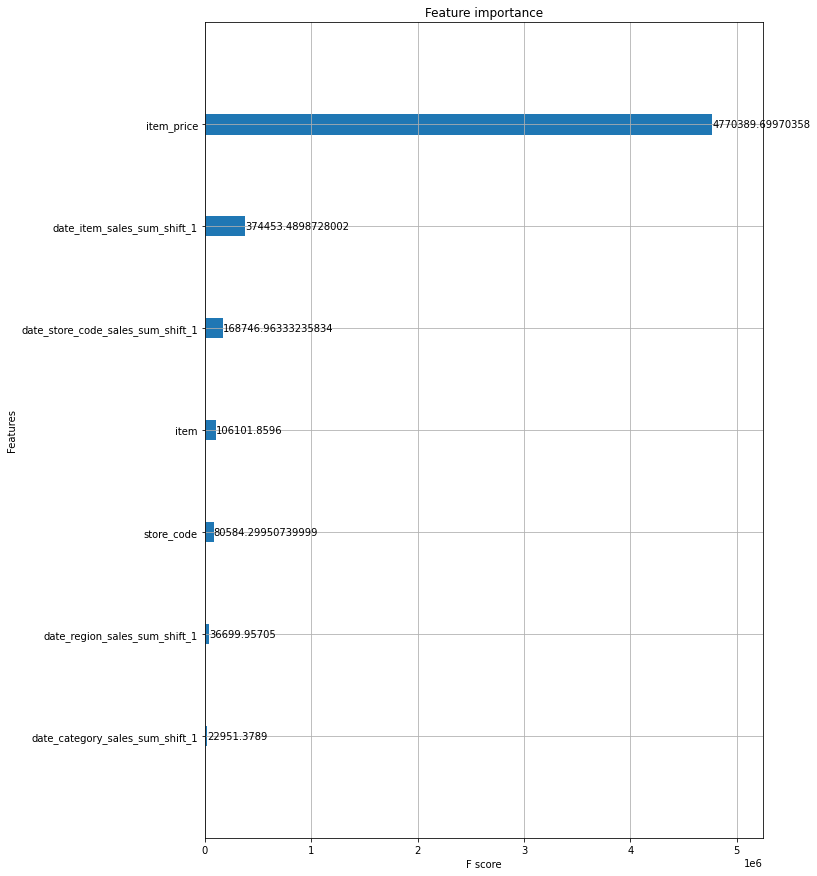

In [83]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
plot_importance(model, importance_type = "gain", ax = ax);

<a id = "predict_and_model_evaluation_1"></a>
# Predict and model evaluation
[Go back to the table of contents](#table_of_contents)

In [84]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

0.012515932321548462

In [85]:
if "sales_predicted" in X_test.columns:
    X_test.drop("sales_predicted", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["sales_predicted"] = np.clip(Y_test_predict, 0, 30)

In [86]:
X_test.head()

,item_price,region,store_code,category,item,department,date_store_code_sales_sum_shift_1,date_category_sales_sum_shift_1,date_item_sales_sum_shift_1,date_department_sales_sum_shift_1,date_region_sales_sum_shift_1,sales_predicted
588000,6.17,1,1,0,3,0,0.0,0.0,0.0,0.0,0.0,19.712070
588001,6.17,1,2,0,3,0,0.0,0.0,0.0,0.0,0.0,19.712070
588002,0.00,1,3,0,3,0,0.0,0.0,0.0,0.0,0.0,0.012516
588003,0.64,1,2,0,7,0,0.0,0.0,0.0,0.0,0.0,27.028660
588004,0.00,1,0,0,8,0,0.0,0.0,0.0,0.0,0.0,0.012516


In [87]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 588000 to 597799
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   item_price                         9800 non-null   float64
 1   region                             9800 non-null   int64  
 2   store_code                         9800 non-null   int64  
 3   category                           9800 non-null   int64  
 4   item                               9800 non-null   int64  
 5   department                         9800 non-null   int64  
 6   date_store_code_sales_sum_shift_1  9800 non-null   float64
 7   date_category_sales_sum_shift_1    9800 non-null   float64
 8   date_item_sales_sum_shift_1        9800 non-null   float64
 9   date_department_sales_sum_shift_1  9800 non-null   float64
 10  date_region_sales_sum_shift_1      9800 non-null   float64
 11  sales_predicted                    9800 non-null 

In [101]:
X_test.to_csv("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/PREDICTION_DF_9.csv", index = False)

In [89]:
X_test["unique_id"] = X_test["store_code"].map(str) + "-" + X_test["item"].map(str)

In [90]:
X_test_short = X_test[["unique_id", "sales_predicted"]]

In [91]:
# PATH_DATA = "../input/df-time-series"

In [94]:
test_index = pd.read_csv("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/DF_FINAL.csv", index_col = 0)

In [95]:
test_index.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5345528 entries, 0 to 5345527
Data columns (total 27 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               object 
 1   item             object 
 2   category         object 
 3   department       object 
 4   store            object 
 5   store_code       object 
 6   region           object 
 7   date             object 
 8   sell_price       float64
 9   year             int64  
 10  week             int64  
 11  sales            float64
 12  month            int64  
 13  day              int64  
 14  weekday_int      float64
 15  weekend_sales    float64
 16  event_dummy      float64
 17  event_sales      float64
 18  units            int64  
 19  summer_sales     int64  
 20  christmas_sales  int64  
 21  sales_2011       int64  
 22  sales_2012       int64  
 23  sales_2013       int64  
 24  sales_2014       int64  
 25  sales_2015       int64  
 26  sales_2016       int64  
dtypes: float64(6

In [96]:
test_index["id"] = test_index["id"].map(str)
test_index.rename(columns = {"id":"unique_id"}, inplace = True)

In [97]:
FINAL_SALES_PRED_DF = pd.merge(test_index, X_test_short, left_on = "unique_id", right_on = "unique_id", how = "left")

In [100]:
FINAL_SALES_PRED_DF.to_csv("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/FINAL_SALES_PRED_NY_DF_9.csv", index = False)

In [99]:
FINAL_SALES_PRED_DF.head(2)

,unique_id,item,category,department,store,store_code,region,date,sell_price,year,...,units,summer_sales,christmas_sales,sales_2011,sales_2012,sales_2013,sales_2014,sales_2015,sales_2016,sales_predicted
0,ACCESORIES_1_002_BOS_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,2011-03-07,5.28,2011,...,4,0,0,4,0,0,0,0,0,NaN
1,ACCESORIES_1_002_BOS_3,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Back_Bay,BOS_3,Boston,2011-03-07,5.28,2011,...,2,0,0,2,0,0,0,0,0,NaN
